# Pipeline para regresión PCA 

En este pequeño documento ilustramos el concepto de **pipeline** que resulta de gran utilidad para encadenar procesos en modelización predictiva y que sklearn implementa estupendamente! 

La idea es poder generar procesos multi-etapa para la modelización predictiva en un solo gran proceso. De esta forma, con la matriz de entrada, se aplicarán una serie de procesos de forma secuencial, proporcionando el resultado final que en este caso seguramente sea algo así como una clasificación supervisada pero podrían generarse los procesos que se necesiten. 

El ejemplo que implementamos es una regresión logística PCA, es decir, aplicar un PCA para la reducción de dimensiones de la matriz de predictores y posteriormente una regresión logística para la predicción de una variable de tipo dicotómico. Este es un proceso bastante popular puesto que evita problemas de colinealidad entre predictores. 


In [1]:
import numpy as np 
import pandas as pd 

df= pd.read_csv("College.csv")

df.head()

,Unnamed: 0,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [2]:
df.set_index(['Unnamed: 0'],inplace=True)

In [3]:
df.select_dtypes(include=np.number).corr().style.background_gradient(cmap='coolwarm').format(precision=3)

,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
Apps,1.000,0.943,0.847,0.339,0.352,0.814,0.398,0.050,0.165,0.133,0.179,0.391,0.369,0.096,-0.090,0.260,0.147
Accept,0.943,1.000,0.912,0.192,0.247,0.874,0.441,-0.026,0.091,0.114,0.201,0.356,0.338,0.176,-0.160,0.125,0.067
Enroll,0.847,0.912,1.000,0.181,0.227,0.965,0.513,-0.155,-0.040,0.113,0.281,0.331,0.308,0.237,-0.181,0.064,-0.022
Top10perc,0.339,0.192,0.181,1.000,0.892,0.141,-0.105,0.562,0.371,0.119,-0.093,0.532,0.491,-0.385,0.455,0.661,0.495
Top25perc,0.352,0.247,0.227,0.892,1.000,0.199,-0.054,0.489,0.331,0.116,-0.081,0.546,0.525,-0.295,0.418,0.527,0.477
F.Undergrad,0.814,0.874,0.965,0.141,0.199,1.000,0.571,-0.216,-0.069,0.116,0.317,0.318,0.300,0.280,-0.229,0.019,-0.079
P.Undergrad,0.398,0.441,0.513,-0.105,-0.054,0.571,1.000,-0.254,-0.061,0.081,0.320,0.149,0.142,0.233,-0.281,-0.084,-0.257
Outstate,0.050,-0.026,-0.155,0.562,0.489,-0.216,-0.254,1.000,0.654,0.039,-0.299,0.383,0.408,-0.555,0.566,0.673,0.571
Room.Board,0.165,0.091,-0.040,0.371,0.331,-0.069,-0.061,0.654,1.000,0.128,-0.199,0.329,0.375,-0.363,0.272,0.502,0.425
Books,0.133,0.114,0.113,0.119,0.116,0.116,0.081,0.039,0.128,1.000,0.179,0.027,0.100,-0.032,-0.040,0.112,0.001


In [4]:
# Eliminar la variable que indica el nombre de la universidad
#df.drop(columns="Unnamed: 0", inplace=True)

In [5]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
calculate_bartlett_sphericity(df.select_dtypes(include=np.number))

(11820.11581086419, 0.0)

In [6]:
from factor_analyzer.factor_analyzer import calculate_kmo
print(calculate_kmo(df.select_dtypes(include=np.number)))

(array([0.77032777, 0.74054264, 0.78224516, 0.75545071, 0.79134192,
       0.81448795, 0.91117179, 0.85022275, 0.86289398, 0.65887331,
       0.89175403, 0.79388167, 0.78848377, 0.89772009, 0.91160799,
       0.85464141, 0.91798795]), 0.8135161828696817)


In [7]:
# O bien esto
exec(open('C:\\Users\\Guille\\Documents\\Material Minería de Datos 2023_2024\\NuestrasFunciones.py').read())
# Aplicamos a fórmula de modelo completo
formC=ols_formula(df,'Private')
formC



'Private ~ Apps + Accept + Enroll + Top10perc + Top25perc + F.Undergrad + P.Undergrad + Outstate + Room.Board + Books + Personal + PhD + Terminal + S.F.Ratio + perc.alumni + Expend + Grad.Rate'

In [8]:
# Importamos la api para fórmulas (en concreto ols para regresión)
from statsmodels.formula.api import logit 

# Ajusto regresión de ejemplo
#modeloCompleto = logit(formC,data=df).fit()
#modeloCompleto.summary()

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score


In [10]:
# Matriz de predictores
X = df.drop('Private', axis=1)
# Variable objetivo para la regresión logística
y = df['Private']

# Partición training-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42888)

Vamos a probar a definir un pipe en el que se escalen los datos, luego se ajuste un PCA que recoja el 50% de la varianza del archivo y, por último, en base a los scores obtenidos, se ajuste un modelo de regresión logística para la predicción de la variable objetivo que indica si el college es privado o no lo es. 

Trataremos de entender y tener acceso a distintas etapas y parámetros del pipe y luego modificar a nuestro gusto cualquiera de los parámetros de cualquiera de los pasos. 

Trabajaremos con el esquema training-test para la evaluación de los resultados obtenidos. 

In [11]:
# Definimos los pasos del pipe
steps = [('scaler', StandardScaler()),
         ('pca', PCA(n_components=0.5)),
         ('clf', LogisticRegression(penalty=None))]

# Construimos el pipeline
pipe_lr = Pipeline(steps)

# Ajustamos el proceso del pipe en training
pipe_lr.fit(X_train, y_train)
# Predicciones en training
train_predictions = pipe_lr.predict(X_train)
# Predicciones en test
test_predictions = pipe_lr.predict(X_test)

print("TRAIN:")
print(classification_report(y_train, train_predictions))

print("TEST:")
print(classification_report(y_test, test_predictions))

TRAIN:
              precision    recall  f1-score   support

          No       0.89      0.79      0.84       184
         Yes       0.92      0.96      0.94       476

    accuracy                           0.92       660
   macro avg       0.91      0.88      0.89       660
weighted avg       0.91      0.92      0.91       660

TEST:
              precision    recall  f1-score   support

          No       0.84      0.75      0.79        28
         Yes       0.92      0.96      0.94        89

    accuracy                           0.91       117
   macro avg       0.88      0.85      0.87       117
weighted avg       0.90      0.91      0.90       117



In [12]:
# Score final (accuracy)
pipe_lr.score(X_test,y_test)

0.905982905982906

Muy buen ajuste de la regresión logística PCA a los datos de training y también buena capacidad de generalización al conjunto de test. Un modelo maravilloso que acierta el 93% de los registros y los clasifica como college privado o no privado. 

Seguidamente indagamos en los distintos pasos y el acceso a componentes. 

In [13]:
# Acceso a los distintos pasos del pipe
pipe_lr.steps

[('scaler', StandardScaler()),
 ('pca', PCA(n_components=0.5)),
 ('clf', LogisticRegression(penalty=None))]

In [14]:
# Acceso a los parámetros
pipe_lr.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('pca', PCA(n_components=0.5)),
  ('clf', LogisticRegression(penalty=None))],
 'verbose': False,
 'scaler': StandardScaler(),
 'pca': PCA(n_components=0.5),
 'clf': LogisticRegression(penalty=None),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'pca__copy': True,
 'pca__iterated_power': 'auto',
 'pca__n_components': 0.5,
 'pca__n_oversamples': 10,
 'pca__power_iteration_normalizer': 'auto',
 'pca__random_state': None,
 'pca__svd_solver': 'auto',
 'pca__tol': 0.0,
 'pca__whiten': False,
 'clf__C': 1.0,
 'clf__class_weight': None,
 'clf__dual': False,
 'clf__fit_intercept': True,
 'clf__intercept_scaling': 1,
 'clf__l1_ratio': None,
 'clf__max_iter': 100,
 'clf__multi_class': 'auto',
 'clf__n_jobs': None,
 'clf__penalty': None,
 'clf__random_state': None,
 'clf__solver': 'lbfgs',
 'clf__tol': 0.0001,
 'clf__verbose': 0,
 'clf__warm_start': False}

In [15]:
# Acceso al PCA (los pasos siempre empiezan en 0 como los index de python, el segundo es el 1)
pipe_lr.steps[1][1]

PCA(n_components=0.5)

In [16]:
# Acceso al PCA y número de componentes con el 50% de la variabilidad
pipe_lr.steps[1][1].components_.shape[0]

2

In [17]:
# Podemos actualizar algunos de los parámetros internos del pipe. Por ejemplo, fijar 3 componentes ppales.
pipe_lr.set_params(pca__n_components=0.8)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.8)),
                ('clf', LogisticRegression(penalty=None))])

In [18]:
# Volvemos a ajustar con el cambio
pipe_lr.fit(X_train, y_train)
# Predicciones para training
train_predictions = pipe_lr.predict(X_train)
# Predicciones para test
test_predictions = pipe_lr.predict(X_test)

print("TRAIN:")
print(classification_report(y_train, train_predictions))

print("TEST:")
print(classification_report(y_test, test_predictions))

TRAIN:
              precision    recall  f1-score   support

          No       0.90      0.83      0.86       184
         Yes       0.93      0.96      0.95       476

    accuracy                           0.93       660
   macro avg       0.92      0.90      0.91       660
weighted avg       0.92      0.93      0.92       660

TEST:
              precision    recall  f1-score   support

          No       0.86      0.86      0.86        28
         Yes       0.96      0.96      0.96        89

    accuracy                           0.93       117
   macro avg       0.91      0.91      0.91       117
weighted avg       0.93      0.93      0.93       117



In [19]:
# Extraer el PCA como paso 1,1
model = pipe_lr.steps[1][1]

# Número de componentes
n_pcs= model.components_.shape[0]
n_pcs


6

In [20]:
model.explained_variance_ratio_


array([0.31747231, 0.26967221, 0.06823235, 0.05881803, 0.05614539,
       0.04802297])

In [21]:
# Acceso a las variables más importantes en la construcción de PC1 y PC2
initial_feature_names = X_train.columns
most_important = [np.abs(model.components_[i]).argmax() for i in     range(n_pcs)]
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
most_important_names

['Top10perc', 'F.Undergrad', 'Books', 'Terminal', 'Room.Board', 'Books']

In [22]:
# Posible acceso a la matriz de puntuaciones o scores del modelo (nuevas variables para predecir la variable objetivo)
model.transform(StandardScaler().fit_transform(X_train))

array([[-3.71899273e+00, -3.67324012e-03,  2.49719551e-01,
         4.10671656e-01, -1.35003878e+00, -3.54887998e-01],
       [ 7.14077446e+00, -7.51625836e-01,  6.83705602e-01,
         1.69885065e+00, -3.12898194e-01, -1.22354083e+00],
       [-2.37515052e+00,  2.91499138e+00, -9.18712726e-01,
        -6.81913932e-01,  5.47254043e-02, -8.70409229e-01],
       ...,
       [-1.25481251e-01,  3.29153139e+00,  2.17526362e+00,
        -1.66058558e+00,  5.04447686e-01, -2.95048490e+00],
       [ 1.83442110e+00, -1.39221256e+00, -1.01149720e+00,
        -9.28655890e-01, -1.63093232e-01,  2.40473696e-01],
       [-2.15841990e+00, -4.17059420e-01, -1.03130616e+00,
        -3.45674555e-01, -1.41269149e-02,  8.84517125e-01]])

In [23]:
# Acceso a las cargas
model.components_

array([[ 2.22887912e-01,  1.82689701e-01,  1.48465825e-01,
         3.57346616e-01,  3.46548564e-01,  1.26094161e-01,
        -5.31239240e-04,  3.06602102e-01,  2.58900468e-01,
         5.53565264e-02, -7.54511687e-02,  3.19675017e-01,
         3.19234760e-01, -1.91431622e-01,  2.20298474e-01,
         3.24450468e-01,  2.58593805e-01],
       [ 3.48421295e-01,  3.84731597e-01,  4.11380410e-01,
        -5.59761725e-02, -1.67529646e-02,  4.23833274e-01,
         3.25842774e-01, -2.25175871e-01, -1.11056475e-01,
         5.83362133e-02,  2.27882775e-01,  7.66864503e-02,
         6.61592369e-02,  2.36190175e-01, -2.33621830e-01,
        -1.13966498e-01, -1.41935348e-01],
       [-4.63790566e-02, -7.76090387e-02, -8.11098736e-02,
         8.61712018e-03, -3.81249298e-02, -6.33577220e-02,
         1.14540483e-01,  7.99741852e-02,  2.22377777e-01,
         7.22296013e-01,  4.21209376e-01, -1.29175403e-01,
        -6.37770609e-02, -2.53794822e-01, -1.85031577e-01,
         2.21704149e-01, -2.0

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Principal component', ylabel='Eigenvalue'>)

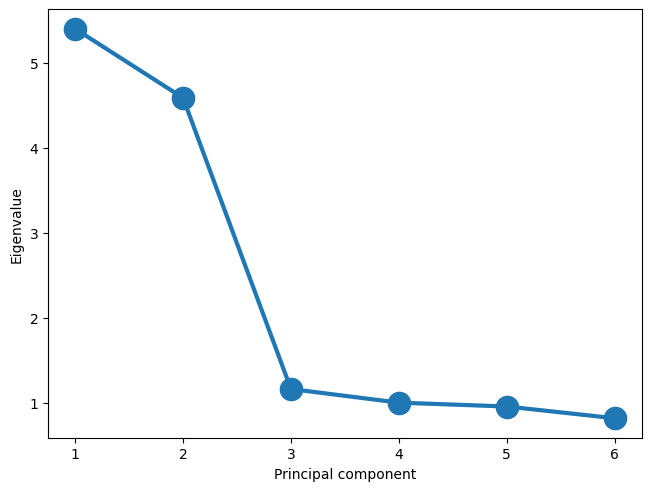

In [24]:
from psynlig import pca_scree
pca_scree(model, marker='o', markersize=16, lw=3)

Con este código podemos ir indagando en la construcción de pipes y el acceso a los distintos elementos dentro de los mismos para poder programar procesos complejos con fácil ejecución. Seguramente esto será de mucha utilidad de cara a Machine Learning y proyectos de distinta índole que puedan presentarse en el camino. 

No es el objetivo de nuestro módulo profundizar mucho en todo esto pero con estas pequeñas nociones y sobretodo teniendo el código por ahí controlado, seremos capaces de echar mano en el futuro para desarrollar un poco más nuestras habilidades de programación para la predicción con nuestro querido python y el maravilloso mundo sklearn. 

Que aproveche! 